In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import adjusted_rand_score

data = pd.read_csv("sa.csv")

documents = []
labels = []
for index, row in data.iterrows() :
    documents.append(row['Title'])
    labels.append(row['Tone'])
    
vectorizer = TfidfVectorizer(stop_words = 'english')
X = vectorizer.fit_transform(documents)

In [2]:
from sklearn.metrics.pairwise import cosine_similarity

dist = 1 - cosine_similarity(X)

In [3]:
# # LIST UNTUK NANTI DIPREDIKSI
# testing = ['Teenager being offensive towards patient with autism', 
#            'New mental institution in U.S', 
#            'A lot of people get benefits from the new mental health institution',
#            'Man suffered from depression', 
#            'Free mental health aid']

# k-Means

In [4]:
from sklearn.cluster import KMeans

true_k = 3
model = KMeans(n_clusters = true_k, init = 'k-means++', max_iter  = 100, n_init = 1)
model.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
    n_clusters=3, n_init=1, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [5]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]
print()
print()

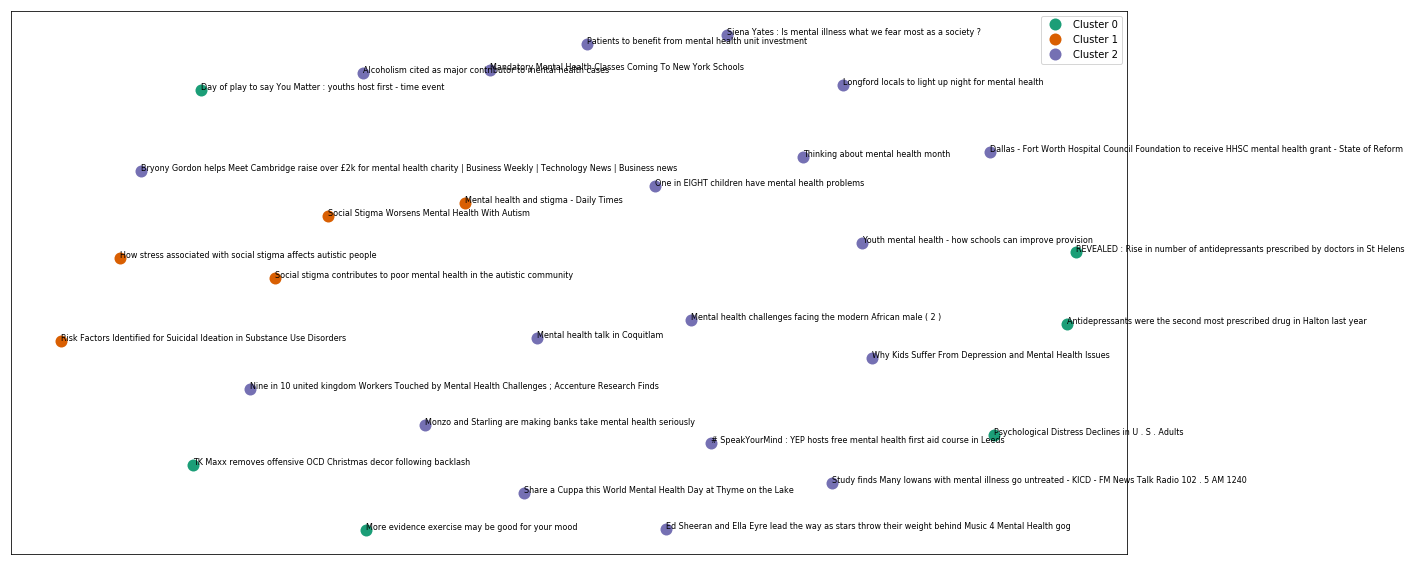

In [6]:
clusters = model.labels_.tolist()
res = {'title': documents, 'cluster': clusters, 'init_tone': labels}
cluster_res = pd.DataFrame(data = res, index = [clusters], columns = ['title', 'cluster', 'init_tone'])

cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3'}

cluster_names = {0: 'Cluster 0', 
                 1: 'Cluster 1', 
                 2: 'Cluster 2'}

#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=documents)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(20, 10)) # set size
# ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelleft=False)
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(df)):
    ax.text(df.loc[i]['x'], df.loc[i]['y'], df.loc[i]['title'], size=8)  

#uncomment the below to save the plot if need be
plt.savefig('clusters_small_noaxes.png', dpi=200)

plt.show() #show the plot

In [7]:
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print

In [8]:
# # PREDIKSI DARI VAR TESTING
# Y = vectorizer.transform(testing)
# prediction = model.predict(Y)
# print("Prediction", prediction)

In [9]:
from sklearn import metrics

# NILAI
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, model.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, model.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, model.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, model.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, model.labels_, sample_size=1000))
print("Davies Bouldin Index: %0.3f"
      % metrics.davies_bouldin_score(X.toarray(), model.labels_))

Homogeneity: 0.239
Completeness: 0.289
V-measure: 0.262
Adjusted Rand-Index: 0.116
Silhouette Coefficient: 0.019
Davies Bouldin Index: 3.325


C:\Users\asus\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


# Ward Hierarchical Clustering

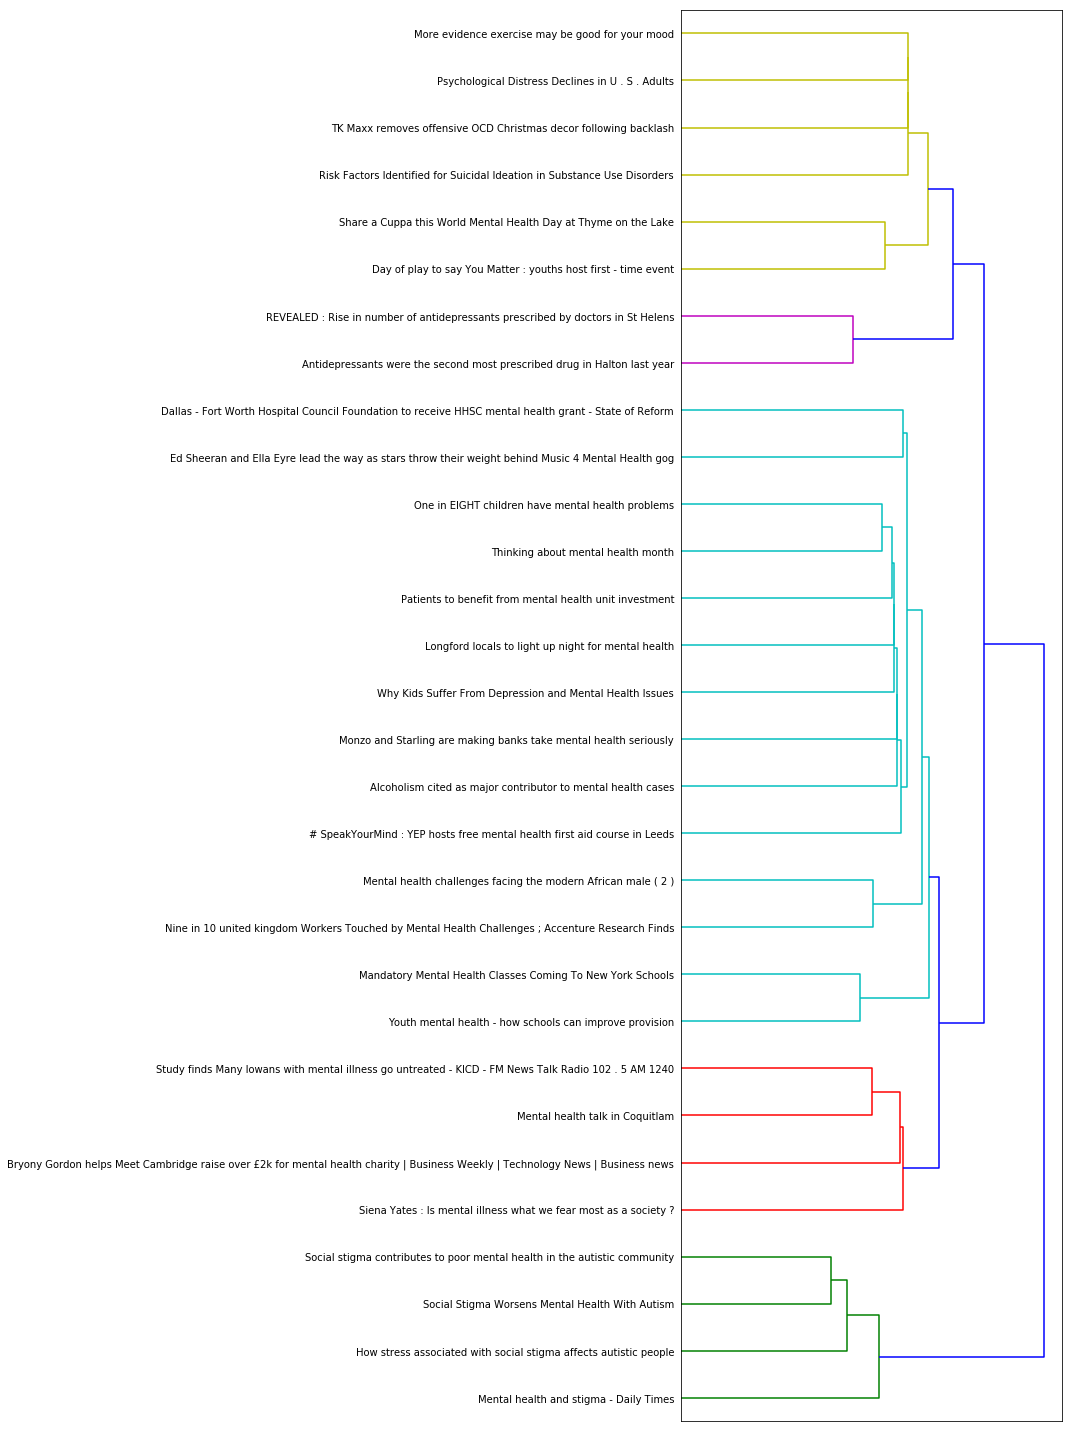

In [10]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import ward, dendrogram

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation = "right", labels = documents);

plt.tick_params(\
    axis = 'x',          # changes apply to the x-axis
    which = 'both',      # both major and minor ticks are affected
    bottom = False,      # ticks along the bottom edge are off
    top = False,         # ticks along the top edge are off
    labelbottom = False)

plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters

In [11]:
from scipy.cluster.hierarchy import fcluster

assignments = fcluster(linkage_matrix, 1.7, 'distance')
cluster_output = pd.DataFrame({'title': documents, 'cluster': assignments})
cluster_output.sort_values('cluster')

,title,cluster
29,Mental health and stigma - Daily Times,1
25,How stress associated with social stigma affec...,1
22,Social Stigma Worsens Mental Health With Autism,1
28,Social stigma contributes to poor mental healt...,1
27,Mental health challenges facing the modern Afr...,2
26,Why Kids Suffer From Depression and Mental Hea...,2
24,One in EIGHT children have mental health problems,2
23,Siena Yates : Is mental illness what we fear m...,2
19,Study finds Many Iowans with mental illness go...,2
18,Alcoholism cited as major contributor to menta...,2


In [12]:
h_labels = cluster_output['cluster']

In [13]:
from sklearn import metrics

# NILAI
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, h_labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels, h_labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, h_labels))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, h_labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, h_labels, sample_size=1000))
print("Davies Bouldin Index: %0.3f"
      % metrics.davies_bouldin_score(X.toarray(), h_labels))

Homogeneity: 0.168
Completeness: 0.199
V-measure: 0.182
Adjusted Rand-Index: 0.048
Silhouette Coefficient: 0.020
Davies Bouldin Index: 3.440


C:\Users\asus\Anaconda3\lib\site-packages\sklearn\metrics\cluster\unsupervised.py:342: RuntimeWarning: divide by zero encountered in true_divide
  score = (intra_dists[:, None] + intra_dists) / centroid_distances


In [14]:
# linkage_matrix

In [15]:
# from sklearn.cluster import AffinityPropagation
# from sklearn import metrics


# af = AffinityPropagation().fit(X)
# # cluster_centers_indices = af.cluster_centers_indices_
# labels_test = af.labels_

# # n_clusters_ = len(cluster_centers_indices)
# n_clusters_ = 3

# print ('Estimated number of clusters: %d' % n_clusters_)
# print ("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, labels_test))
# print ("Completeness: %0.3f" % metrics.completeness_score(labels, labels_test))
# print ("V-measure: %0.3f" % metrics.v_measure_score(labels, labels_test))
# print ("Adjusted Rand Index: %0.3f" % \
#     metrics.adjusted_rand_score(labels, labels_test))
# print ("Adjusted Mutual Information: %0.3f" % \
#     metrics.adjusted_mutual_info_score(labels, labels_test))
# print ("Silhouette Coefficient: %0.3f" %
#        metrics.silhouette_score(X, labels_test, sample_size=1000))
# print("Silhouette Davies Bouldin Index: %0.3f"
#       % metrics.davies_bouldin_score(X.toarray(), model.labels_))

# ##############################################################################
# # Plot result
# import pylab as pl
# from itertools import cycle

# pl.close('all')
# pl.figure(1)
# pl.clf()

# colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
# for k, col in zip(range(n_clusters_), colors):
#     class_members = labels == k
#     cluster_center = X[cluster_centers_indices[k]]
#     pl.plot(X[class_members, 0], X[class_members, 1], col + '.')
#     pl.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
#             markeredgecolor='k', markersize=14)
#     for x in X[class_members]:
#         pl.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

# pl.title('Estimated number of clusters: %d' % n_clusters_)
# pl.show()

In [16]:
# print __doc__

# import numpy as np
# from sklearn.cluster import AffinityPropagation
# from sklearn import metrics
# from sklearn.datasets.samples_generator import make_blobs

# ##############################################################################
# # Generate sample data
# centers = [[1, 1], [-1, -1], [1, -1]]
# X, labels_true = make_blobs(n_samples=300, centers=centers, cluster_std=0.5)

# ##############################################################################
# # Compute similarities
# X_norms = np.sum(X ** 2, axis=1)
# S = - X_norms[:, np.newaxis] - X_norms[np.newaxis, :] + 2 * np.dot(X, X.T)
# p = 10 * np.median(S)

# ##############################################################################
# # Compute Affinity Propagation
# af = AffinityPropagation().fit(S, p)
# cluster_centers_indices = af.cluster_centers_indices_
# labels = af.labels_

# n_clusters_ = len(cluster_centers_indices)

# print 'Estimated number of clusters: %d' % n_clusters_
# print "Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels)
# print "Completeness: %0.3f" % metrics.completeness_score(labels_true, labels)
# print "V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels)
# print "Adjusted Rand Index: %0.3f" % \
#     metrics.adjusted_rand_score(labels_true, labels)
# print "Adjusted Mutual Information: %0.3f" % \
#     metrics.adjusted_mutual_info_score(labels_true, labels)
# D = (S / np.min(S))
# print ("Silhouette Coefficient: %0.3f" %
#        metrics.silhouette_score(D, labels, metric='precomputed'))

# ##############################################################################
# # Plot result
# import pylab as pl
# from itertools import cycle

# pl.close('all')
# pl.figure(1)
# pl.clf()

# colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
# for k, col in zip(range(n_clusters_), colors):
#     class_members = labels == k
#     cluster_center = X[cluster_centers_indices[k]]
#     pl.plot(X[class_members, 0], X[class_members, 1], col + '.')
#     pl.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
#             markeredgecolor='k', markersize=14)
#     for x in X[class_members]:
#         pl.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

# pl.title('Estimated number of clusters: %d' % n_clusters_)
# pl.show()